In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import bernoulli
from mnist import MNIST
import matplotlib.pyplot as plt
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn import naive_bayes

In [2]:
def train_test_split(X,y,test_ratio):
    mask = np.random.rand(len(X))>test_ratio
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[np.invert(mask)]
    y_test = y[np.invert(mask)]
    return X_train, y_train, X_test, y_test

In [3]:
class GuassianNB():
        
    def fit(self,X_train, y_train):
        self.min_std = 0.00000001
        self.nclass = np.unique(y_train).shape[0]
        self.class_labels = np.unique(y_train)
        self.nfeature = X_train.shape[1]
        self.means = np.zeros((self.nclass,self.nfeature))
        self.stds = np.zeros((self.nclass,self.nfeature))
        self.log_py = np.zeros(self.nclass)
        for i in range(self.nclass):
            # Get the boolean vector to filter for y = i
            mask = [l==self.class_labels[i] for l in y_train]
            self.means[i] = np.nanmean(X_train[mask],axis=0)
            # To avoid devide by 0/very small value issue, add a min for standard deviation to min_std = 0.00000001
            self.stds[i] = np.clip(np.nanstd(X_train[mask],axis=0),self.min_std,None)
            # calculate p(y=i)
            self.log_py[i] = np.log(np.sum(mask)/len(y_train))
    
    def predict(self,X_test):
        samples = X_test.shape[0]
        log_py_on_x = np.zeros((samples,self.nclass))
        for i in range(self.nclass):
            log_py_on_x[:,i] = self.log_py[i] + np.nansum(np.log(norm.pdf(X_test,self.means[i],self.stds[i])),axis=1)
        label = self.class_labels[np.argmax(log_py_on_x, axis=1)]
        return label    
        
    
    def score(self,X_test, y_test):
        y_predict = self.predict(X_test)
        return (y_predict == y_test).mean()     

In [4]:
class BernoulliNB():
        
    def fit(self,X_train, y_train):
        self.nclass = np.unique(y_train).shape[0]
        self.class_labels = np.unique(y_train)
        self.nfeature = X_train.shape[1]
        self.pblacks = np.zeros((self.nclass,self.nfeature))
        self.log_py = np.zeros(self.nclass)
        for i in range(self.nclass):
            # Get the boolean vector to filter for y = i
            mask = [l==self.class_labels[i] for l in y_train]
            self.pblacks[i] = np.mean(X_train[mask], axis=0)/255
            # calculate p(y=i)
            self.log_py[i] = np.log(np.sum(mask)/len(y_train))
    
    def predict(self,X_test):
        samples = X_test.shape[0]
        log_py_on_x = np.zeros((samples,self.nclass))
        for i in range(self.nclass):
            log_py_on_x[:,i] = self.log_py[i] + np.sum(np.log(bernoulli.pmf(X_test/255,self.pblacks[i])),axis=1)
        label = self.class_labels[np.argmax(log_py_on_x, axis=1)]
        return label       
    
    def score(self,X_test, y_test):
        y_predict = self.predict(X_test)
        return (y_predict == y_test).mean()    

In [5]:
# Test Guassian Naive Bayes with pima-indian-diabetes dataset
data = pd.read_csv("data\pima-indians-diabetes.csv", header = None, names =['preg','plas','pres','skin','test','mass','pedi','age','class'])
X=np.array(data[['preg','plas','pres','skin','test','mass','pedi','age']])
y=np.array(data['class'])

accuracy =[]
for i in range(100):
    X_train, y_train, X_test, y_test = train_test_split(X,y,0.2)
    nb = GuassianNB()
    nb.fit(X_train, y_train)
    accuracy.append(nb.score(X_test, y_test))
print("average accuracy without missing value adjustment: "+str(np.mean(accuracy)))

# regard zero value for 'pres', 'skin', 'mass' ,'age' as missing value
for i in (2,3,5,7):
    X[:,i][X[:,i]==0]=np.nan
accuracy =[]
for i in range(100):
    X_train, y_train, X_test, y_test = train_test_split(X,y,0.2)
    nb = GuassianNB()
    nb.fit(X_train, y_train)
    accuracy.append(nb.score(X_test, y_test))
print("average accuracy with zero value adjusted as missing value for 'pres','skin','mass','age' attributes: "+str(np.mean(accuracy)))

average accuracy without missing value adjustment: 0.7507494038469942
average accuracy with zero value adjusted as missing value for 'pres','skin','mass','age' attributes: 0.7455881667142005


C:\Users\rayso\AppData\Local\conda\conda\envs\tensorflow_env\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\rayso\AppData\Local\conda\conda\envs\tensorflow_env\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


In [6]:
# Test Guassian Naive Bayes with pima-indian-diabetes dataset
# Compare with sklearn Guassian/Bernoulli Naive Bayes
data = pd.read_csv("data\pima-indians-diabetes.csv", header = None, names =['preg','plas','pres','skin','test','mass','pedi','age','class'])
X=np.array(data[['preg','plas','pres','skin','test','mass','pedi','age']])
y=np.array(data['class'])
accuracy =[]
for i in range(10):
    X_train, y_train, X_test, y_test = train_test_split(X,y,0.2)
    nb = naive_bayes.GaussianNB()
    nb.fit(X_train, y_train)
    accuracy.append(nb.score(X_test, y_test))
print("(sklearn) average accuracy without missing value adjustment: "+str(np.mean(accuracy)))


(sklearn) average accuracy without missing value adjustment: 0.7479630988521355


In [7]:
# Test Guassian/Bernoulli Naive Bayes with mnist datase
# MNIST dataset preprocessing with 1. thresholding 2.potentially stretched bounding box with size (20,20)
class MNIST_Preproc():
    def __init__(self, image_size=28, thresholding=50, stretchedBB_flag=False, resize=20):
        self.image_size = image_size
        self.stretchedB_flag = stretchedBB_flag
        self.resize = resize
        self.thresholding = thresholding
    
    def preproc(self,X):
        self.n=X.shape[0]        
        
        if self.stretchedB_flag: 
            X_reshape = X.reshape(self.n,self.image_size,self.image_size).astype(float)
            X_stretched_boundingbox = np.zeros((self.n,self.resize,self.resize))
            for i in range(self.n):
                X_stretched_boundingbox[i]=self.stretched_boundingbox_single(X_reshape[i])
            X_stretched_boundingbox=X_stretched_boundingbox.reshape(self.n,self.resize*self.resize)
            
            # Image processing, thresholding
            X_thresholding = (X_stretched_boundingbox >self.thresholding).astype(float)*255
            
            return X_thresholding
        
        # Image processing, thresholding, threshold at 50
        X_thresholding = (X >self.thresholding).astype(float)*255
        
        return X_thresholding
        
    def stretched_boundingbox_single(self, img):
        lower_bound =  np.where(np.any(img,axis=1))[0][0]
        upper_bound =  np.where(np.any(img,axis=1))[0][-1]
        left_bound =  np.where(np.any(img,axis=0))[0][0]
        right_bound =  np.where(np.any(img,axis=0))[0][-1]
        stretched_boundingbox = cv2.resize(img[lower_bound:upper_bound,left_bound:right_bound], (self.resize, self.resize)) 
        return stretched_boundingbox 

In [8]:
# Test Guassian/Bernoulli Naive Bayes with mnist datase
# 1. Data loading & preprocesing
mndata = MNIST('data')
X_train, y_train = mndata.load_training()
X_test, y_test = mndata.load_testing()

# Preprocessing option1: Stretched Bounding Box with thresholding
img_processor = MNIST_Preproc(stretchedBB_flag=True)
X_train_stretchedBB = img_processor.preproc(np.array(X_train))
X_test_stretchedBB = img_processor.preproc(np.array(X_test))
# Preprocessing option2: Original data (without stretched bounding box) with thresholding
img_processor = MNIST_Preproc(stretchedBB_flag=False)
X_train = img_processor.preproc(np.array(X_train))
X_test = img_processor.preproc(np.array(X_test))
# Convert labels to array
y_train = np.array(y_train)
y_test = np.array(y_test)



In [9]:

def model(stretchedBB_flag, classifier, NB_model, use_sklearn=False):
    if stretchedBB_flag:
        train_feature = X_train_stretchedBB
        test_feature = X_test_stretchedBB
    else:
        train_feature = X_train
        test_feature = X_test
    if use_sklearn == False:
        if (classifier == 'NB') & (NB_model =='Normal'):
            classifier = GuassianNB()
        if (classifier == 'NB') & (NB_model =='Bernoulli'):
            classifier = BernoulliNB() 
    else:
        if (classifier == 'NB') & (NB_model =='Normal'):
            classifier = naive_bayes.GaussianNB()
        if (classifier == 'NB') & (NB_model =='Bernoulli'):
            classifier = naive_bayes.BernoulliNB() 
    
    classifier.fit(train_feature,y_train)
    
    return classifier.score(test_feature,y_test)

In [10]:
# Test Guassian/Bernoulli Naive Bayes with mnist datase
# 2. Fit into Guassian/Bernoulli Naive Bayes with mnist datase
print("NB-Normal with stretched-boundbing-box: "+str(model(stretchedBB_flag=True, classifier='NB', NB_model='Normal')))
print("NB-Bernoulli with stretched-boundbing-box: "+str(model(stretchedBB_flag=True, classifier='NB', NB_model='Bernoulli')))
print("NB-Normal with no touch data: "+str(model(stretchedBB_flag=False, classifier='NB', NB_model='Normal')))
print("NB-Bernoulli with no touch data: "+str(model(stretchedBB_flag=False, classifier='NB', NB_model='Bernoulli')))

NB-Normal with stretched-boundbing-box: 0.8285
NB-Bernoulli with stretched-boundbing-box: 0.8217


C:\Users\rayso\AppData\Local\conda\conda\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


NB-Normal with no touch data: 0.4631


C:\Users\rayso\AppData\Local\conda\conda\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


NB-Bernoulli with no touch data: 0.8445


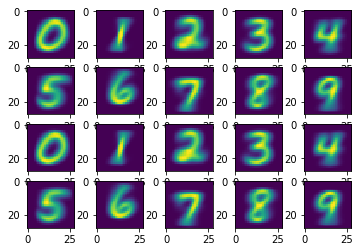

In [11]:
# Test Guassian/Bernoulli Naive Bayes with mnist datase
# 3.Visualization Guassian/Bernoulli Naive Bayes trained (on original data with thresholding) classifier with mnist datase
nb = GuassianNB()
nb.fit(X_train,y_train)

for i in range(10):
    plt.subplot(4, 5, i+1)
    plt.imshow(nb.means[i].reshape(28,28))

bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X_train,y_train)

for i in range(10):
    plt.subplot(4, 5, i+11)
    plt.imshow(np.array(bernoulli_nb.pblacks[i]).reshape(28,28))


In [12]:
# Test Guassian/Bernoulli Naive Bayes with mnist datase
# 4. Compare with sklearn Guassian/Bernoulli Naive Bayes
print("(sklearn) NB-Normal with stretched-boundbing-box: "+str(model(stretchedBB_flag=True, classifier='NB', NB_model='Normal',use_sklearn=True)))
print("(sklearn) NB-Bernoulli with stretched-boundbing-box: "+str(model(stretchedBB_flag=True, classifier='NB', NB_model='Bernoulli',use_sklearn=True)))
print("(sklearn) NB-Normal with no touch data: "+str(model(stretchedBB_flag=False, classifier='NB', NB_model='Normal',use_sklearn=True)))
print("(sklearn) NB-Bernoulli with no touch data: "+str(model(stretchedBB_flag=False, classifier='NB', NB_model='Bernoulli',use_sklearn=True)))

(sklearn) NB-Normal with stretched-boundbing-box: 0.8285
(sklearn) NB-Bernoulli with stretched-boundbing-box: 0.8215
(sklearn) NB-Normal with no touch data: 0.5398
(sklearn) NB-Bernoulli with no touch data: 0.8445
